In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from sklearn.metrics import balanced_accuracy_score, precision_recall_fscore_support, confusion_matrix, classification_report, cohen_kappa_score
import os
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Dense, Flatten, Dropout

In [2]:
epochs = 20
learning_rate = 3.9e-5
# Parameters
IMG_HEIGHT = 224
IMG_WIDTH = 224
BATCH_SIZE = 32
AUTOTUNE = tf.data.AUTOTUNE
folder_path = './../../datasets/dataset1'
num_classes = 5
validation_split = 0.2
test_split = 0.2  # Proportion of the data to use for testing

# Load image file paths and their corresponding labels
image_paths = []
labels = []

class_names = sorted(os.listdir(folder_path))
class_indices = {name: i for i, name in enumerate(class_names)}

for class_name in class_names:
    class_path = os.path.join(folder_path, class_name)
    for file_name in os.listdir(class_path):
        file_path = os.path.join(class_path, file_name)
        image_paths.append(file_path)
        labels.append(class_indices[class_name])

image_paths = np.array(image_paths)
labels = np.array(labels)

# Split the data into training, validation, and test sets
train_paths, test_paths, train_labels, test_labels = train_test_split(image_paths, labels, test_size=test_split, stratify=labels, random_state=42)
train_paths, val_paths, train_labels, val_labels = train_test_split(train_paths, train_labels, test_size=validation_split, stratify=train_labels, random_state=42)

# Function to load and preprocess the images
def preprocess_image(image_path, label):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [IMG_HEIGHT, IMG_WIDTH])
    image = image / 255.0  # Normalize to [0,1]
    label = tf.one_hot(label, num_classes)
    return image, label

# Create TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_paths, train_labels))
train_dataset = train_dataset.map(preprocess_image, num_parallel_calls=AUTOTUNE)
train_dataset = train_dataset.shuffle(buffer_size=len(train_paths)).batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)

val_dataset = tf.data.Dataset.from_tensor_slices((val_paths, val_labels))
val_dataset = val_dataset.map(preprocess_image, num_parallel_calls=AUTOTUNE)
val_dataset = val_dataset.batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)

test_dataset = tf.data.Dataset.from_tensor_slices((test_paths, test_labels))
test_dataset = test_dataset.map(preprocess_image, num_parallel_calls=AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)



In [5]:
def balanced_accuracy(y_true, y_pred):
    y_true = tf.argmax(y_true, axis=1)
    y_pred = tf.argmax(y_pred, axis=1)
    return tf.py_function(
        func=lambda y_true, y_pred: balanced_accuracy_score(
            y_true.numpy(), y_pred.numpy()),
        inp=[y_true, y_pred],
        Tout=tf.float64)


def fscore(y_true, y_pred):
    y_true = tf.cast(tf.argmax(y_true, axis=1), tf.int32)
    y_pred = tf.cast(tf.argmax(y_pred, axis=1), tf.int32)

    def compute_fscore(y_true, y_pred):
        _, _, fscore, _ = precision_recall_fscore_support(
            y_true, y_pred, average='macro', zero_division=0)
        return fscore

    return tf.py_function(func=compute_fscore, inp=[y_true, y_pred], Tout=tf.float64)

# Custom Kappa Metric
def kappa_score(y_true, y_pred):
    y_true = tf.argmax(y_true, axis=1)
    y_pred = tf.argmax(y_pred, axis=1)
    kappa_score = tf.py_function(func=cohen_kappa_score, inp=[y_true, y_pred], Tout=tf.float32)
    return kappa_score

In [6]:

metrics = [
    'accuracy',
    tf.keras.metrics.AUC(),
    balanced_accuracy,
    fscore,
    kappa_score,
    tf.keras.metrics.Precision(),
    tf.keras.metrics.Recall()
]

In [7]:
import warnings
warnings.filterwarnings('ignore', message="A single label was found in y_true and y_pred.")
warnings.filterwarnings('ignore', message="y_pred contains classes not in y_true") 
warnings.filterwarnings('ignore', message="A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.") 


def accuracyGraph(history):
    train_accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    print ('train_accuracy-> ', train_accuracy)
    print ('val_accuracy-> ', val_accuracy)
    print ('train_loss-> ', train_loss)
    print ('val_loss-> ', val_loss)

    epochs_no = range(len(train_accuracy) + 1)


    # Plot accuracy
    plt.figure(figsize=(14, 7))
    plt.subplot(2, 2, 1)
    plt.plot(epochs_no, [0] + train_accuracy, 'b', label='Train Accuracy')
    plt.plot(epochs_no, [0] + val_accuracy, 'r', label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot loss
    plt.subplot(2, 2, 2)
    plt.plot(epochs_no, [0] + train_loss, 'b', label='Train Loss')
    plt.plot(epochs_no, [0] + val_loss, 'r', label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.figure(figsize=(14, 7))
    plt.subplot(2, 2, 3)
    plt.plot(epochs_no, [0] + val_accuracy, 'b')
    plt.title('Model Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')

    # Plot loss
    plt.subplot(2, 2, 4)
    plt.plot(epochs_no, [0] + val_loss, 'r')
    plt.title('Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')

    plt.show()

    
def show_confusion_matrix(model):
    # Get true labels and predictions
    y_true = []
    y_pred = []

    for images, labels in test_dataset:
        y_true.extend(np.argmax(labels.numpy(), axis=1))
        predictions = model.predict(images)
        y_pred.extend(np.argmax(predictions, axis=1))
    
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    # Generate classification report
    print(classification_report(y_true, y_pred, target_names=[str(i) for i in range(num_classes)]))
    
    # Compute confusion matrix
    conf_matrix = confusion_matrix(y_true, y_pred)
    print(conf_matrix)

    # Plot confusion matrix
    def plot_confusion_matrix(cm, class_names):
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.title('Confusion Matrix')
        plt.show()

    plot_confusion_matrix(conf_matrix, [str(i) for i in range(num_classes)])

In [8]:
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(IMG_WIDTH, IMG_HEIGHT, 3))
# Add custom top layers
# Add custom top layers
for layer in base_model.layers:
    layer.trainable = False
    
x = Flatten()(base_model.output)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(5, activation='softmax')(x)  # 5 classes for diabetic retinopathy
model = Model(inputs=base_model.input, outputs=output)

87910968/87910968 [==============================] - 3s 0us/step


In [9]:
# Compile the model with the custom loss function
model.compile(optimizer=Adam(learning_rate=learning_rate), loss="categorical_crossentropy", metrics=metrics)
print(model.summary())


# Train the model
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=epochs,
    batch_size=BATCH_SIZE
)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 111, 111, 32  864         ['input_1[0][0]']                
                                )                                                                 


                                                                                                  
 batch_normalization (BatchNorm  (None, 111, 111, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                                 
                                                                                                  
 activation (Activation)        (None, 111, 111, 32  0           ['batch_normalization[0][0]']    
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 109, 109, 32  9216        ['activation[0][0]']             
                                )                                                                 
                                                                                                  
 batch_nor

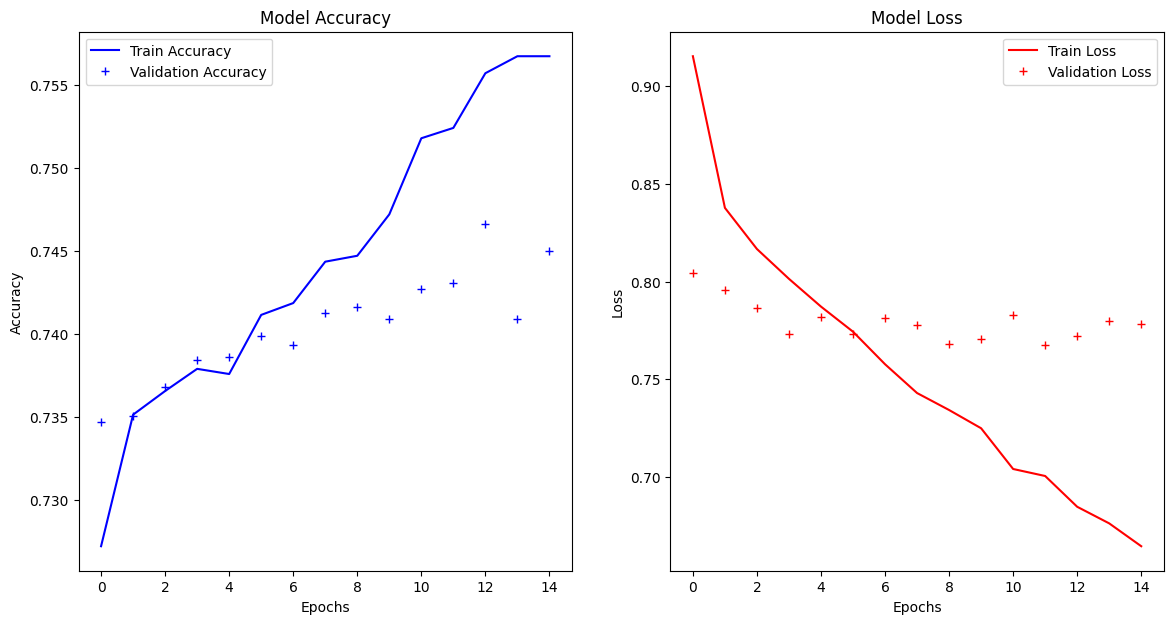

In [10]:
accuracyGraph(history)

1/1 [==============================] - 1s 998ms/step
              precision    recall  f1-score   support

           0       0.76      0.99      0.86      5162
           1       0.00      0.00      0.00       489
           2       0.36      0.08      0.13      1058
           3       0.56      0.03      0.05       175
           4       0.46      0.13      0.20       142

    accuracy                           0.74      7026
   macro avg       0.43      0.24      0.25      7026
weighted avg       0.63      0.74      0.65      7026

[[5101    0   52    1    8]
 [ 484    0    4    0    1]
 [ 968    0   82    1    7]
 [ 118    0   47    5    5]
 [  82    0   40    2   18]]


c:\Users\Computing\anaconda3\envs\AML\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Computing\anaconda3\envs\AML\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Computing\anaconda3\envs\AML\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


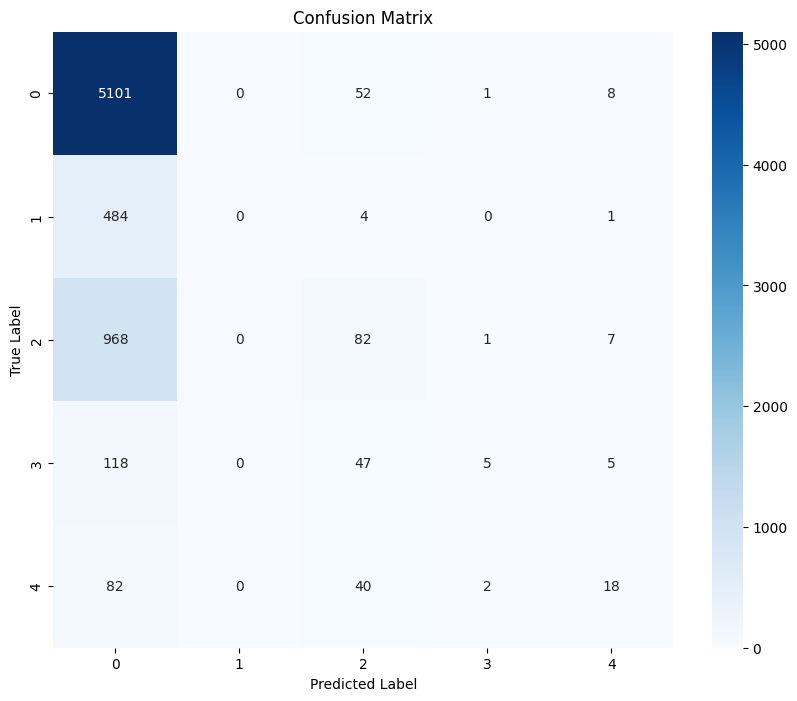

In [11]:
show_confusion_matrix(model)

In [12]:
_metrices = model.evaluate(test_dataset)
# _metrices = model.evaluate(test_generator, steps=test_generator.samples // batch_size)

print("Test Metrices", _metrices)

220/220 [==============================] - 11s 51ms/step - loss: 0.7963 - accuracy: 0.7410 - auc: 0.9178 - balanced_accuracy: 0.2984 - fscore: 0.2689 - kappa_score: 0.0952 - precision: 0.7699 - recall: 0.7115
Test Metrices [0.796276867389679, 0.7409621477127075, 0.9177525043487549, 0.2984413206577301, 0.26894161105155945, 0.09515124559402466, 0.7699060440063477, 0.7115001678466797]


In [13]:


x = base_model.output
x = GlobalAveragePooling2D()(x)
# x = Dense(1024, activation='relu')(x)
x = tf.keras.layers.Dropout(0.1)(x)
x = tf.keras.layers.Dense(256, activation='relu')(x)
x = tf.keras.layers.Dropout(0.1)(x)
x = tf.keras.layers.Dense(256, activation='relu')(x)
x = tf.keras.layers.Dropout(0.1)(x)
predictions = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Fine-tuning: Unfreeze some layers of the base model
for layer in base_model.layers[:249]:  # Adjust the index as needed
    layer.trainable = False
for layer in base_model.layers[249:]:
    layer.trainable = True


# Recompile the model with a lower learning rate
# model.compile(optimizer=Adam(lr=0.00001), loss=loss_fn, metrics=['accuracy'])
model.compile(optimizer=Adam(lr=learning_rate), loss="categorical_crossentropy", metrics=metrics)

# Continue training (fine-tuning)
# Train the model
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=epochs,
    batch_size=BATCH_SIZE
)

Epoch 1/15


c:\Users\Computing\anaconda3\envs\AML\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


 24/703 [>.............................] - ETA: 49s - loss: 1.2021 - accuracy: 0.6081 - auc: 0.9093 - balanced_accuracy: 0.3055 - fscore: 0.2278 - kappa_score: nan - precision: 0.7691 - recall: 0.6719

c:\Users\Computing\anaconda3\envs\AML\lib\site-packages\sklearn\metrics\_classification.py:730: RuntimeWarning: invalid value encountered in scalar divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)


703/703 [==============================] - 93s 82ms/step - loss: 0.8256 - accuracy: 0.7320 - auc: 0.9102 - balanced_accuracy: 0.2801 - fscore: 0.2425 - kappa_score: nan - precision: 0.7637 - recall: 0.6979 - val_loss: 0.7511 - val_accuracy: 0.7472 - val_auc: 0.9265 - val_balanced_accuracy: 0.3162 - val_fscore: 0.2872 - val_kappa_score: 0.1126 - val_precision: 0.7755 - val_recall: 0.7148
Epoch 2/15
703/703 [==============================] - 83s 85ms/step - loss: 0.7040 - accuracy: 0.7531 - auc: 0.9352 - balanced_accuracy: 0.3571 - fscore: 0.3325 - kappa_score: 0.2020 - precision: 0.7941 - recall: 0.7039 - val_loss: 0.7419 - val_accuracy: 0.7548 - val_auc: 0.9263 - val_balanced_accuracy: 0.3660 - val_fscore: 0.3363 - val_kappa_score: 0.1959 - val_precision: 0.7922 - val_recall: 0.6975
Epoch 3/15
703/703 [==============================] - 88s 91ms/step - loss: 0.5605 - accuracy: 0.7935 - auc: 0.9594 - balanced_accuracy: 0.4784 - fscore: 0.4531 - kappa_score: 0.4121 - precision: 0.8347 - r

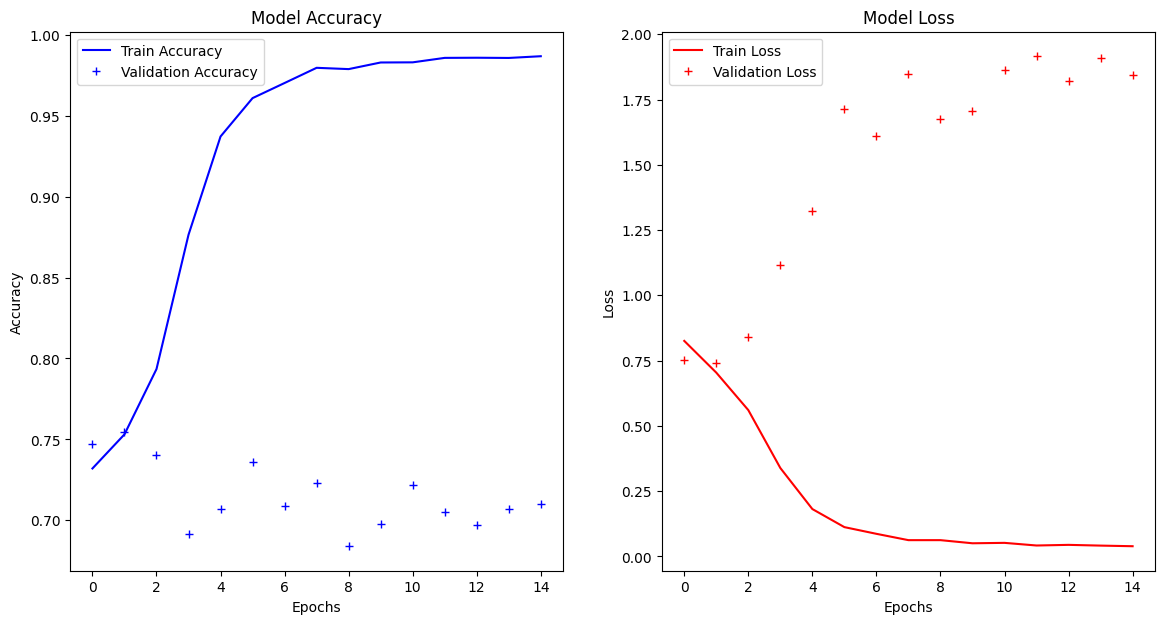

In [14]:
accuracyGraph(history)

1/1 [==============================] - 1s 845ms/step
              precision    recall  f1-score   support

           0       0.79      0.90      0.84      5162
           1       0.09      0.05      0.06       489
           2       0.34      0.20      0.25      1058
           3       0.36      0.18      0.24       175
           4       0.31      0.34      0.32       142

    accuracy                           0.70      7026
   macro avg       0.38      0.33      0.34      7026
weighted avg       0.65      0.70      0.67      7026

[[4621  191  295   16   39]
 [ 421   25   38    1    4]
 [ 726   53  213   24   42]
 [  57    9   54   31   24]
 [  47    4   28   15   48]]


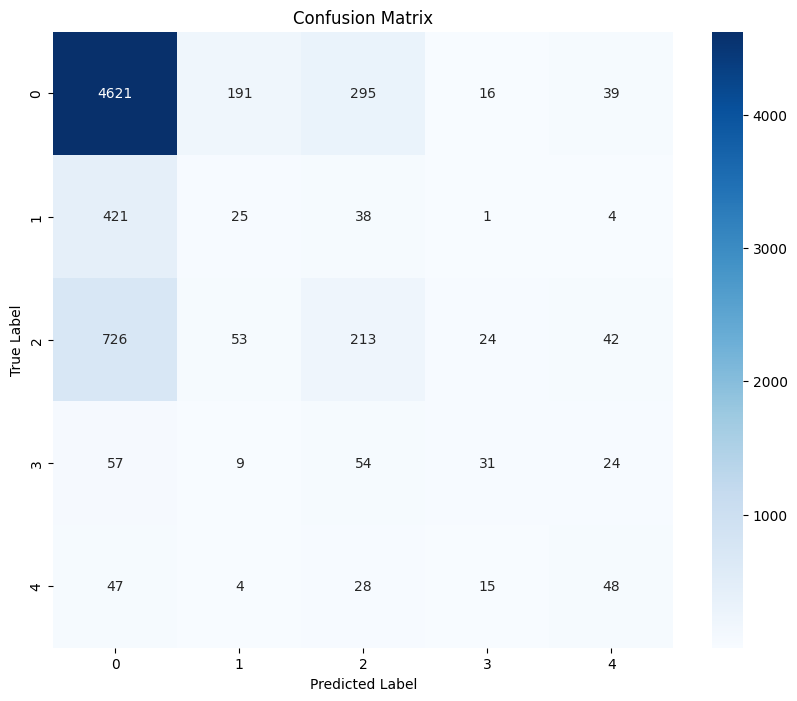

In [15]:
show_confusion_matrix(model)

In [16]:
_metrices = model.evaluate(test_dataset)
# _metrices = model.evaluate(test_generator, steps=test_generator.samples // batch_size)

print("Test Metrices", _metrices)

220/220 [==============================] - 11s 51ms/step - loss: 1.9785 - accuracy: 0.7028 - auc: 0.8720 - balanced_accuracy: 0.3598 - fscore: 0.3190 - kappa_score: 0.1833 - precision: 0.7077 - recall: 0.6997
Test Metrices [1.9785491228103638, 0.7028180956840515, 0.8719618320465088, 0.3597520589828491, 0.3190408945083618, 0.1832893043756485, 0.7077454924583435, 0.6996868848800659]
